## Sentiment Shift Analysis

### Objective
The objective of this project is to move beyond traditional document-level sentiment classification and analyze how sentiment evolves within a single review. By performing sentence-level sentiment analysis, the project aims to detect sentiment transitions (e.g., negative to positive or vice versa) across the flow of a review, providing deeper insights into user opinions and emotional progression.

### Summary
In this project, long movie reviews are first segmented into individual sentences to preserve discourse structure. Each sentence is converted into semantic representations using pretrained GloVe word embeddings and processed through a Bidirectional LSTM model to capture contextual meaning and word order. Since sentence-level labels are unavailable, weak supervision is applied by inheriting review-level sentiment labels for sentence-level training.

The trained model predicts sentiment probabilities for each sentence independently, which are then mapped back to their original order within the review. These probabilities are visualized to illustrate sentiment progression, enabling the identification of sentiment shifts across sentences. This approach provides a more granular and interpretable understanding of user sentiment compared to traditional bag-of-words–based sentiment analysis methods.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import regex as re

In [ ]:
df=pd.read_csv('IMDB Dataset.csv')

In [ ]:
text=df['review'][:1000]

In [ ]:
text

,review
0,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...
2,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is..."
...,...
995,Nothing is sacred. Just ask Ernie Fosselius. T...
996,I hated it. I hate self-aware pretentious inan...
997,I usually try to be professional and construct...
998,If you like me is going to see this in a film ...


In [ ]:
import re

def clean_text_for_sentence_analysis(text):
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', ' ', text)

    # Keep sentence punctuation, remove other symbols
    text = re.sub(r"[^a-zA-Z0-9.,!?'\s]", ' ', text)

    # Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [ ]:
text.apply(clean_text_for_sentence_analysis)

,review
0,one of the other reviewers has mentioned that ...
1,a wonderful little production. the filming tec...
2,i thought this was a wonderful way to spend ti...
3,basically there's a family where a little boy ...
4,petter mattei's love in the time of money is a...
...,...
995,nothing is sacred. just ask ernie fosselius. t...
996,i hated it. i hate self aware pretentious inan...
997,i usually try to be professional and construct...
998,if you like me is going to see this in a film ...


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])  # negative=0, positive=1


In [ ]:
y=df['sentiment'][:1000]

In [ ]:
y

,sentiment
0,1
1,1
2,1
3,0
4,1
...,...
995,1
996,0
997,0
998,0


In [ ]:
X_sub = text
y_sub = y


In [ ]:

from nltk.tokenize import sent_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
sentences = []
sentence_labels = []

for review, label in zip(X_sub, y_sub):
    review_sentences = sent_tokenize(review)

    for sent in review_sentences:
        sentences.append(sent)
        sentence_labels.append(label)

In [ ]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)

sequences = tokenizer.texts_to_sequences(sentences)


In [ ]:
MAX_LEN = 40

X_seq = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')
y_seq = np.array(sentence_labels)


In [ ]:
pip install gensim -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 48.6 MB/s eta 0:00:00


In [ ]:
import gensim.downloader as api

glove_model = api.load("glove-wiki-gigaword-100")


[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:

EMBEDDING_DIM = 100
print("GloVe loaded with dimension:", glove_model.vector_size)

GloVe loaded with dimension: 100


In [ ]:
EMBEDDING_DIM = 100
word_index = tokenizer.word_index
num_words = min(20000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i < num_words and word in glove_model:
        embedding_matrix[i] = glove_model[word]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

model = Sequential([
    Embedding(
        input_dim=num_words,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),

    Bidirectional(LSTM(64)),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,897,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,897,200 (7.24 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,897,200 (7.24 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

model.fit(
    X_seq,
    y_seq,
    validation_split=0.2,
    epochs=6,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/6
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.5473 - loss: 0.6891 - val_accuracy: 0.6109 - val_loss: 0.6537
Epoch 2/6
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.6196 - loss: 0.6551 - val_accuracy: 0.5817 - val_loss: 0.6700
Epoch 3/6
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.6545 - loss: 0.6266 - val_accuracy: 0.6439 - val_loss: 0.6268
Epoch 4/6
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.6697 - loss: 0.6171 - val_accuracy: 0.6362 - val_loss: 0.6260
Epoch 5/6
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.6788 - loss: 0.6004 - val_accuracy: 0.6243 - val_loss: 0.6355
Epoch 6/6
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.6826 - loss: 0.5908 - val_accuracy: 0.6405 - val_loss: 0.6198


In [ ]:
from nltk.tokenize import sent_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Take one review
review_text = X_sub[189]

# Split into sentences
review_sentences = sent_tokenize(review_text)

# Convert sentences to sequences
seq = tokenizer.texts_to_sequences(review_sentences)

# Pad sequences
pad = pad_sequences(seq, maxlen=MAX_LEN, padding='post')

# Predict sentiment probabilities
probs = model.predict(pad).flatten()

# Display sentence-wise sentiment
for i, (sent, p) in enumerate(zip(review_sentences, probs), 1):
    label = "Positive" if p >= 0.5 else "Negative"
    print(f"S{i} ({label}, {p:.2f}): {sent}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
S1 (Negative, 0.47): I don't believe there has ever been a more evil or wicked television program to air in the United States as The 700 Club.
S2 (Negative, 0.40): They are today's equivalent to the Ku Klux Klan of the 20th century.
S3 (Positive, 0.81): Their hatred of all that is good and sweet and human and pure is beyond all ability to understand.
S4 (Negative, 0.19): Their daily constant attacks upon millions and millions of Americans, as well as billions of humans the world over, who don't happen to share their bigoted, cruel, monstrous, and utterly insane view of humanity is beyond anything television has ever seen.
S5 (Negative, 0.16): The lies they spout and the ridiculous lies they try to pass off as truth, such as the idea of "life after death" or "god" or "sin" or "the devil" is so preposterous that they actually seem mentally ill, so lost are they in their fantasy.
S6 (Negative, 0.21): Sane people know that religion is a drug and should

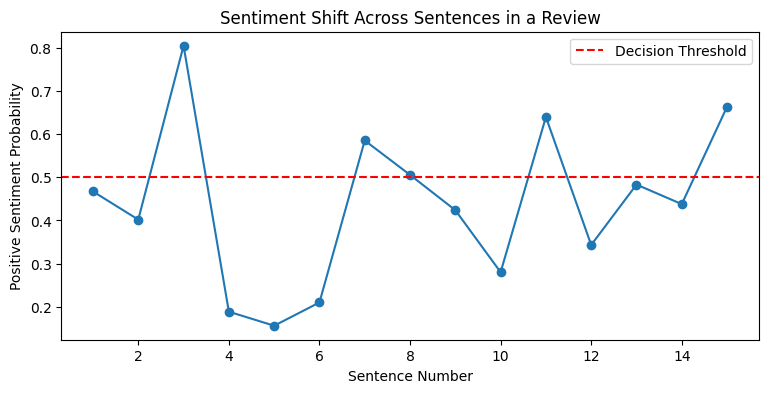

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 4))
plt.plot(range(1, len(probs) + 1), probs, marker='o')
plt.axhline(0.5, color='red', linestyle='--', label='Decision Threshold')
plt.xlabel("Sentence Number")
plt.ylabel("Positive Sentiment Probability")
plt.title("Sentiment Shift Across Sentences in a Review")
plt.legend()
plt.show()
